In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [4]:
import numpy as np # 科学计算工具
import pandas as pd # 数据处理工具
import matplotlib.pyplot as plt # 数据可视化基础工具
import seaborn as sns #高阶数据可视化
from scipy.stats import skew, norm # 计算skew和norm的函数
import math # 数学处理函数
plt.style.use('ggplot')  # 设置绘图风格
from sklearn.preprocessing import MinMaxScaler # 数据归一化工具
from sklearn.ensemble import GradientBoostingRegressor ## GBDT
from lightgbm import LGBMRegressor # LGBM
from xgboost import XGBRegressor # xgboost
from sklearn.metrics import mean_squared_error, make_scorer  ## 计算均方差函数
from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import warnings
warnings.filterwarnings("ignore")

In [6]:
#导入训练集数据 （本地使用）
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv') # 其中的参数为路径
#导入测试集数据
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')   # 其中的参数为路径
SalePrice = np.log(train['SalePrice'])  # 对房价做对数化处理
data= pd.concat([train,test], keys=['train', 'test'])# X 是 training data Y 是 testing data
data=data.drop(["Id"],axis=1) # 因为原始数据中的数据索引和预测模型的构建没有关系，直接删掉

## 删去缺失值超过15%的特征
x =  data.isnull().sum().sort_values(ascending=False)/len(data)
missing_ratio = data.isnull().sum().sort_values(ascending=False)/len(data)
missing_ratio_2 = missing_ratio.copy()
missing_ratio_2.drop(missing_ratio_2[missing_ratio_2 == 0].index, inplace =True)
data = data.drop(missing_ratio[missing_ratio > 0.15].index,1) 

In [7]:
data.shape

(2919, 73)

In [8]:
data.head()

MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
train 0          60       RL     8450   Pave      Reg         Lvl    AllPub   
      1          20       RL     9600   Pave      Reg         Lvl    AllPub   
      2          60       RL    11250   Pave      IR1         Lvl    AllPub   
      3          70       RL     9550   Pave      IR1         Lvl    AllPub   
      4          60       RL    14260   Pave      IR1         Lvl    AllPub   

        LotConfig LandSlope Neighborhood  ... OpenPorchSF EnclosedPorch  \
train 0    Inside       Gtl      CollgCr  ...          61             0   
      1       FR2       Gtl      Veenker  ...           0             0   
      2    Inside       Gtl      CollgCr  ...          42             0   
      3    Corner       Gtl      Crawfor  ...          35           272   
      4       FR2       Gtl      NoRidge  ...          84             0   

        3SsnPorch ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType  \
train 0         0           0         0        0       2    2008       WD   
      1         0           0         0        0       5    2007       WD   
      2         0           0         0        0       9    2008       WD   
      3         0           0         0        0       2    2006       WD   
      4         0           0         0        0      12    2008       WD   

        SaleCondition  
train 0        Normal  
      1        Normal  
      2        Normal  
      3       Abnorml  
      4        Normal  

[5 rows x 73 columns]

In [9]:
#对于列名为'MSSubClass'、'YrSold'、'MoSold'的特征列，将列中的数据类型转化为string格式。
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
#按照以下各个特征列的实际情况，依次处理各个特征列中的空值（.fillna()方法）
data['Functional'] = data['Functional'].fillna('Typ') #空值填充为str型数据'Typ'
data['Electrical'] = data['Electrical'].fillna("SBrkr") #空值填充为str型数据"SBrkr"
data['KitchenQual'] = data['KitchenQual'].fillna("TA") #空值填充为str型数据"TA"


#对于列名为'Exterior1st'、'Exterior2nd'、'SaleType'的特征列，使用列中的众数填充空值。
# 1.先查找数据列中的众数：使用df.mode()[]方法
#v解释：df.mode(0或1,0表示对列查找，1表示对行查找)[需要查找众数的df列的index（就是df中的第几列）]，将返回数据列中的众数
# 2.使用.fillna()方法进行填充
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0]) 
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])


#对于列名为'GarageYrBlt', 'GarageArea', 'GarageCars'的特征列，使用0填充空值。
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

#对于列名为'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'的特征列，使用字符串'None'填充空值。
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
    
    
#对于列名为'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'的特征列，使用字符串'None'填充空值。
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [10]:
#聚合函数（按某一列关键字分组）groupby，它的特点是：将返回与传入方法的矩阵维度相同的单个序列。
#transform是与groupby（pandas中最有用的操作之一）通常组合使用，它对传入方法的矩阵进行维度不变的变换。具体变换方法写在括号中，通常会使用匿名函数，对传入矩阵的所有元素进行操作。
#对于features矩阵，按照'MSSubClass'列中的元素分布进行分组，被分组的数据列是'MSZoning'列。data.groupby(被作为索引的列的名称)[被分组的数据列的名称]
#data.groupby('MSSubClass')['MSZoning']后，得到的是一个以'MSSubClass'为索引，以'MSZoning'为数据列的矩阵。
#.transform()方法将对'MSZoning'数据列进行()内的变换，它将返回和传入矩阵同样维度的矩阵。
#括号内是匿名函数，将对传入矩阵中的空值进行填充，使用的填充元素是传入矩阵中的众数。
data['MSZoning'] = data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [11]:
#判断出features矩阵中列为对象的列，将列名存入objects叔祖。对于data矩阵中的各个列对象，将其列中的空值填充为'None'
objects = []
for i in data.columns:
    if data[i].dtype == object:
        objects.append(i)
data.update(data[objects].fillna('None'))

#对于整型和浮点型数据列，使用0填充其中的空值。
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numerics.append(i)
data.update(data[numerics].fillna(0))

In [12]:
######################数字型数据列偏度校正-【开始】#######################
#使用skew()方法，计算所有整型和浮点型数据列中，数据分布的偏度（skewness）。
#偏度是统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。亦称偏态、偏态系数。 
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

#以0.5作为基准，统计偏度超过此数值的高偏度分布数据列，获取这些数据列的index。
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#对高偏度数据进行处理，将其转化为正态分布。
#Box和Cox提出的变换可以使线性回归模型满足线性性、独立性、方差齐次以及正态性的同时，又不丢失信息。
for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))#这是boxcox1p的使用方法
######################数字型数据列偏度校正-【结束】#######################

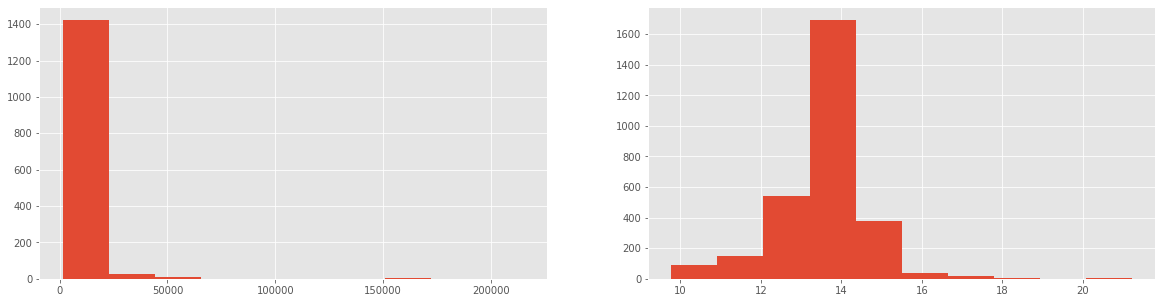

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(train['LotArea'])
plt.subplot(1,2,2)
plt.hist(data['LotArea'])
plt.show()

In [14]:
skew_features

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
dtype: float64

In [15]:
#删除一些特征。df.drop（‘列名’, axis=1）代表将‘列名’对应的列标签（们）沿着水平的方向依次删掉。
data = data.drop(['Utilities', 'Street', ], axis=1)

In [16]:
#融合多个特征，生成新特征。
data['YrBltAndRemod']=data['YearBuilt']+data['YearRemodAdd']
data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                 data['1stFlrSF'] + data['2ndFlrSF'])

data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                              data['WoodDeckSF'])

In [17]:
#简化特征。对于某些分布单调（比如100个数据中有99个的数值是0.9，另1个是0.1）的数字型数据列，进行01取值处理。
data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
#检查特征处理后，特征矩阵的维数，核查特征处理结果。
print("处理之后的特征矩阵维度为:",data.shape)
######################特征删除和融合创建新特征-【结束】###################

处理之后的特征矩阵维度为: (2919, 81)


In [19]:
def mod_outlier(df):
        df1 = df.copy()
        df2 = df1._get_numeric_data()
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)
        k = 0 
        for col in df2.columns:
            print('去除outlier中，进度',k,'/',str(len(df.columns)))
            k = k+1
            for i in range(0,len(df[col])):
                if df2[col][i] < lower_bound[col]:            
                    df2[col][i] = lower_bound[col]
                if df2[col][i] > upper_bound[col]:            
                    df2[col][i] = upper_bound[col]    
        for col in df2.columns:
            df1[col] = df2[col]
        return(df1)
data = mod_outlier(data)

去除outlier中，进度 0 / 81
去除outlier中，进度 1 / 81
去除outlier中，进度 2 / 81
去除outlier中，进度 3 / 81
去除outlier中，进度 4 / 81
去除outlier中，进度 5 / 81
去除outlier中，进度 6 / 81
去除outlier中，进度 7 / 81
去除outlier中，进度 8 / 81
去除outlier中，进度 9 / 81
去除outlier中，进度 10 / 81
去除outlier中，进度 11 / 81
去除outlier中，进度 12 / 81
去除outlier中，进度 13 / 81
去除outlier中，进度 14 / 81
去除outlier中，进度 15 / 81
去除outlier中，进度 16 / 81
去除outlier中，进度 17 / 81
去除outlier中，进度 18 / 81
去除outlier中，进度 19 / 81
去除outlier中，进度 20 / 81
去除outlier中，进度 21 / 81
去除outlier中，进度 22 / 81
去除outlier中，进度 23 / 81
去除outlier中，进度 24 / 81
去除outlier中，进度 25 / 81
去除outlier中，进度 26 / 81
去除outlier中，进度 27 / 81
去除outlier中，进度 28 / 81
去除outlier中，进度 29 / 81
去除outlier中，进度 30 / 81
去除outlier中，进度 31 / 81
去除outlier中，进度 32 / 81
去除outlier中，进度 33 / 81
去除outlier中，进度 34 / 81
去除outlier中，进度 35 / 81
去除outlier中，进度 36 / 81
去除outlier中，进度 37 / 81
去除outlier中，进度 38 / 81
去除outlier中，进度 39 / 81
去除outlier中，进度 40 / 81
去除outlier中，进度 41 / 81


In [20]:
## 数据归一化

X=pd.get_dummies(data)  ## one hot编码

# Fetch all numeric features
numeric_features = X.dtypes[X.dtypes != object].index
skewed_features = X[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    X[i] = np.log1p(X[i])

In [21]:
# 提取训练数据
Train_data=X.loc["train"]

# 提取测试集
Test_data=X.loc["test"]

# 划分输入输出
x = Train_data
y = SalePrice

In [22]:
## 划分交叉验证集
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.1,random_state=10)  ## 你可以调整测试集比例

In [23]:
##GBR

## 对score 进行反向操作
def new_score(x,y):
    return - mean_squared_error(x,y)

In [24]:
## 设置初始GradientBoostingRegressor参数
gbr = GradientBoostingRegressor(n_estimators = 3000,   # 弱学习器的最大迭代次数，或者说最大的弱学习器的个数
                                learning_rate = 0.02,  # 步长
                                max_depth = 4,         # 决策树最大深度
                                max_features = 'sqrt',  # 划分时考虑的最大特征数，划分时最多考虑N^(0.5)个特征
                                min_samples_leaf = 5,  # 叶子节点最少样本数
                                min_samples_split = 8,  # 内部节点再划分所需最小样本数
                                loss = 'huber',         # GBDT算法中的损失函数
                                random_state = 12,     # 控制随机种子
                               )      
gbr.fit(x_train,y_train)  ## 模型训练
rmse = math.sqrt(mean_squared_error(y_test, gbr.predict(x_test))) ## 模型评估
print("【gbr】 mean squares error :",rmse)

【gbr】 mean squares error : 0.09790482653914458


In [25]:
import time
start = time.clock() # 记录开始时间
cv_sets = ShuffleSplit(random_state = 10,test_size = 0.1, n_splits=5) # shuffling our data for cross-validation
parameters_gbr = {
                  'n_estimators':[1000,2000], 
                  'max_depth':[3,4],
                  }
scorer_gbr = make_scorer(new_score)
n_iter_search = 4
grid_obj_gbr = RandomizedSearchCV(gbr, 
                                  parameters_gbr,
                                  scoring = scorer_gbr, 
                                  cv = cv_sets,
                                  verbose = 5,
                                  n_jobs = -1,## 使用的processor的个数
                                  random_state= 99,n_iter=n_iter_search)
grid_fit_gbr = grid_obj_gbr.fit(x_train, y_train)
print('最佳参数为',grid_fit_gbr.best_estimator_)
end = time.clock() # 记录结束时间
xgb_time = (end-start)/60  # 计算训练时间
print('RandomizedSearchCV使用了{0:.2f} 分钟进行参数搜索'.format(xgb_time))

## 给出该模型在测试集上的预测分数
rmse = math.sqrt(mean_squared_error(y_test, grid_fit_gbr.predict(x_test)))
print("【gbr】 mean squares error :",rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   28.4s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.2s finished


最佳参数为 GradientBoostingRegressor(learning_rate=0.02, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=8, n_estimators=2000,
                          random_state=12)
RandomizedSearchCV使用了0.11 分钟进行参数搜索
【gbr】 mean squares error : 0.0969548354091291


In [26]:
##LGBM

## 设置初始LGBMRegressor参数
lightgbm = LGBMRegressor(objective='regression', 
                           num_leaves=4,
                           learning_rate=0.01, 
                           n_estimators=1000,
                           max_bin=100, 
                           bagging_fraction=0.7,
                           bagging_freq=5, 
                           bagging_seed=7,
                           feature_fraction=0.2,
                           feature_fraction_seed=7,
                           verbose=-1,
                           )
lightgbm.fit(x_train,y_train)        ## 模型训练
rmse = math.sqrt(mean_squared_error(y_test, lightgbm.predict(x_test))) ## 模型评估
print("【lightgbm】 mean squares error :",rmse)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
【lightgbm】 mean squares error : 0.10596720059300946


In [27]:
## start = time() # 记录开始时间
parameters_lgbm = {
                  'n_estimators':[3000,4000,5000], 
                  'max_bin':[100,200], 
                  }
scorer_lgbm = make_scorer(new_score)
grid_obj_lgbm = RandomizedSearchCV(lightgbm, 
                                   parameters_lgbm,
                                   scoring = scorer_lgbm, 
                                   cv = cv_sets,
                                   verbose=5,
                                   n_jobs = -1,
                                   random_state= 99
                                  )
grid_fit_lgbm = grid_obj_lgbm.fit(x_train, y_train)
print('最佳参数为',grid_fit_lgbm.best_estimator_)
# end = time() # 记录结束时间
lgbm_time = (end-start)/60  # 计算训练时间
print('LGBM使用了{0:.2f} 分钟进行参数搜索'.format(lgbm_time))
## 给出该模型在测试集上的预测分数
rmse = math.sqrt(mean_squared_error(y_test, grid_fit_lgbm.predict(x_test)))
print("【LGBM】 mean squares error :",rmse)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.3s finished


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
最佳参数为 LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=100, n_estimators=5000, num_leaves=4,
              objective='regression', verbose=-1)
LGBM使用了0.11 分钟进行参数搜索
【LGBM】 mean squares error : 0.10438703041436787


In [28]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=2000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=12)
xgboost.fit(x_train,y_train)  ## 模型训练
y_predictrfr = xgboost.predict(x_test)  ## 模型自预测

rmse = math.sqrt(mean_squared_error(y_test, xgboost.predict(x_test)))
print("【xgboost】 mean squares error :",rmse)

【xgboost】 mean squares error : 0.09743198532587236


In [29]:
## start = time() # Get start time
parameters_xgb = {'n_estimators':[2000,4000], 
             'max_depth':[3,4],
            }
scorer_xgb = make_scorer(new_score)
grid_obj_xgb = RandomizedSearchCV(xgboost, 
                                 parameters_xgb,
                                 scoring = scorer_xgb, 
                                 verbose = 10,
                                 n_jobs = -1,
                                 cv = cv_sets,
                                 random_state= 99)
grid_fit_xgboost = grid_obj_xgb.fit(x_train, y_train)

print('最佳参数为',grid_fit_xgboost.best_estimator_)
# end = time() # 记录结束时间
# lgbm_time = (end-start)/60  # 计算训练时间
print('xgboost使用了{0:.2f} 分钟进行参数搜索'.format(lgbm_time))
## 给出该模型在测试集上的预测分数
rmse = math.sqrt(mean_squared_error(y_test, grid_fit_xgboost.predict(x_test)))
print("【xgboost】 mean squares error :",rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 104.0min remaining: 26.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 113.3min finished


最佳参数为 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=4, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=12,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)
xgboost使用了0.11 分钟进行参数搜索
【xgboost】 mean squares error : 0.09743198532587236
[CV] n_estimators=1000, max_depth=3 ..................................
[CV] ..... n_estimators=1000, max_depth=3, score=-0.010, total=   3.2s
[CV] n_estimators=1000, max_depth=3 ..................................
[CV] ..... n_estimators=1000, max_depth=

In [30]:
##LASSO

from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.0005,
                         max_iter=1000,
                         selection='random',
                        )
Lasso.fit(x_train,y_train)
rmse = math.sqrt(mean_squared_error(y_test, Lasso.predict(x_test)))
print("【Lasso】 mean squares error :",rmse)

【Lasso】 mean squares error : 0.09339713716048807


In [31]:
## start = time() # Get start time
parameters_lasso = {'alpha':[0.0005,0.001,0.002], 
             'max_iter':[1000,2000,3000], 
            'selection':['random','cyclic']
             }
scorer_lasso = make_scorer(new_score)
grid_obj_lasso = RandomizedSearchCV(Lasso, 
                                 parameters_lasso,
                                 scoring = scorer_lasso, 
                                 cv = cv_sets,
                                 random_state= 99)
grid_fit_lasso = grid_obj_lasso.fit(x_train, y_train)

print('最佳参数为',grid_fit_lasso.best_estimator_)
#end = time() # 记录结束时间
# lgbm_time = (end-start)/60  # 计算训练时间
print('lasso使用了{0:.2f} 分钟进行参数搜索'.format(lgbm_time))
## 给出该模型在测试集上的预测分数
rmse = math.sqrt(mean_squared_error(y_test, grid_fit_lasso.predict(x_test)))
print("【lasso】 mean squares error :",rmse)

最佳参数为 Lasso(alpha=0.0005, selection='random')
lasso使用了0.11 分钟进行参数搜索
【lasso】 mean squares error : 0.093401972943006


In [34]:
#RFR

from sklearn.ensemble import RandomForestRegressor  ## 回归决策树

rfr=RandomForestRegressor(n_estimators = 50,  ## 森林中树的个数
                          random_state= 10,  ## 固定随机种子
                          min_impurity_decrease=0.002, # 一般不推荐改动
                          min_weight_fraction_leaf=0.001, # 叶子节点最小的样本权重，如果小于这个值，则会和兄弟节点一起被剪枝。
                          min_samples_split=5,#如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分
                         )
rfr.fit(x_train,y_train)  ## 模型训练
y_predictrfr = rfr.predict(x_test)  ## 模型自预测

In [35]:
cv_sets = ShuffleSplit(random_state = 10, test_size = 0.1, n_splits = 5)
parameters_rfr = {
                 'n_estimators':[1000, 2000]
                 }
scorer_rfr = make_scorer(new_score)
grid_obj_rfr = RandomizedSearchCV(rfr, 
                                 parameters_rfr,
                                 scoring = scorer_rfr, 
                                 cv = cv_sets,
                                 verbose=5,
                                 n_jobs=-1,
                                 random_state= 99)
grid_fit_rfr = grid_obj_rfr.fit(x_train, y_train)

print('最佳参数为',grid_obj_rfr.best_estimator_)
#end = time() # 记录结束时间
# lgbm_time = (end-start)/60  # 计算训练时间
# print('lasso使用了{0:.2f} 分钟进行参数搜索'.format(lgbm_time))
## 给出该模型在测试集上的预测分数
rmse = math.sqrt(mean_squared_error(y_test, grid_fit_rfr.predict(x_test)))
print("【rfr】 mean squares error :",rmse)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   45.2s remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


最佳参数为 RandomForestRegressor(min_impurity_decrease=0.002, min_samples_split=5,
                      min_weight_fraction_leaf=0.001, n_estimators=1000,
                      random_state=10)
【rfr】 mean squares error : 0.1804491004543663


In [37]:
## 计算均方差
import math
from sklearn.metrics import mean_squared_error, make_scorer

rmse = math.sqrt(mean_squared_error(y_test, grid_fit_gbr.predict(x_test)))
print("【gbr】 mean squares error :",rmse)

rmse = math.sqrt(mean_squared_error(y_test, grid_fit_lgbm.predict(x_test)))
print("【lightgbm】 mean squares error :",rmse)

rmse = math.sqrt(mean_squared_error(y_test, grid_fit_xgboost.predict(x_test)))
print("【xgboost】 mean squares error :",rmse)

rmse = math.sqrt(mean_squared_error(y_test, grid_fit_lasso.predict(x_test)))
print("【Lasso】 mean squares error :",rmse)

rmse = math.sqrt(mean_squared_error(y_test, grid_fit_rfr.predict(x_test)))
print("【rfr】 mean squares error :",rmse)

#融合预测结果，提高稳定性
blend_res = 0.2 * grid_fit_gbr.predict(x_test) + \
            0.2 * grid_fit_lgbm.predict(x_test) + \
            0.2 * grid_fit_xgboost.predict(x_test) + \
            0.2 * grid_fit_lasso.predict(x_test) +\
            0.2 * grid_fit_rfr.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, blend_res))
print("【blend_res】 mean squares error :",rmse)

【gbr】 mean squares error : 0.0969548354091291
【lightgbm】 mean squares error : 0.10438703041436787
【xgboost】 mean squares error : 0.09743198532587236
【Lasso】 mean squares error : 0.093401972943006
【rfr】 mean squares error : 0.1804491004543663
【blend_res】 mean squares error : 0.10040005364800209


In [38]:
# 预测
y_model_prerfc_gbr = grid_fit_gbr.predict(Test_data)
y_model_prerfc_lightgbm = grid_fit_lgbm.predict(Test_data)
y_model_prerfc_xgboost = grid_fit_xgboost.predict(Test_data)
y_model_prerfc_lasso = grid_fit_lasso.predict(Test_data)
y_model_prerfc_rfr = grid_fit_rfr.predict(Test_data)

y_model_prerfc = np.exp(0.2*y_model_prerfc_gbr+
                        0.2*y_model_prerfc_lightgbm+
                        0.2*y_model_prerfc_xgboost+
                        0.2*y_model_prerfc_lasso+
                        0.2*y_model_prerfc_rfr
                       )
# 查看预测结果
y_model_prerfc=np.around(y_model_prerfc,0)
prediction=np.array(y_model_prerfc).tolist()
y_model_prerfc

array([122300., 156380., 180927., ..., 160985., 120860., 228243.])

[CV] n_estimators=1000 ...............................................
[CV] .................. n_estimators=1000, score=-0.033, total=  14.5s
[CV] n_estimators=2000 ...............................................
[CV] .................. n_estimators=2000, score=-0.033, total=  31.1s
[CV] n_estimators=1000 ...............................................
[CV] .................. n_estimators=1000, score=-0.028, total=  16.1s
[CV] n_estimators=2000 ...............................................
[CV] .................. n_estimators=2000, score=-0.028, total=  30.6s


In [39]:
# test = test.drop('SalePrice',axis=1)  ## 第二次运行请取消注释

In [40]:
## 保存预测结果
prediction=np.array(y_model_prerfc).tolist()
test.insert(1,column="SalePrice",value=prediction)
## 提取预测结果
predict_sub=test.drop(test.iloc[:,2:],axis=1)
## 查看预测信息
predict_sub.shape

(1459, 2)

[CV] n_estimators=1000 ...............................................
[CV] .................. n_estimators=1000, score=-0.028, total=  14.4s
[CV] n_estimators=1000 ...............................................
[CV] .................. n_estimators=1000, score=-0.052, total=  14.4s
[CV] n_estimators=2000 ...............................................
[CV] .................. n_estimators=2000, score=-0.033, total=  25.9s


In [42]:
# 保存预测结果
predict_sub.to_csv('predictions_stack_gen_v13.csv',index=False)

[CV] n_estimators=1000 ...............................................
[CV] .................. n_estimators=1000, score=-0.033, total=  14.1s
[CV] n_estimators=2000 ...............................................
[CV] .................. n_estimators=2000, score=-0.028, total=  28.7s
[CV] n_estimators=2000 ...............................................
[CV] .................. n_estimators=2000, score=-0.051, total=  21.6s
